<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow2/Tutorial/Getting_started_TensorFlow2/Validation_regularisation_callbacks/Logs_dictionary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash
pip install --no-cache-dir -qU pip wheel
pip install --no-cache-dir -qU numpy pandas matplotlib seaborn scikit-learn
pip install --no-cache-dir -qU tensorflow-gpu
pip check

# Using the logs dictionary

In this reading, we will learn how to take advantage of the `logs` dictionary in Keras to define our own callbacks and check the progress of a model.

In [2]:
import os
import numpy as np
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')
sns.set(font='DejaVu Sans')

import tensorflow as tf
tf.keras.utils.set_random_seed(42)

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

The `logs` dictionary stores the loss value, along with all of the metrics we are using at the end of a batch or epoch.

We can incorporate information from the `logs` dictionary into our own custom callbacks.

Let's see this in action in the context of a model we will construct and fit to the `sklearn` diabetes dataset that we have been using in this module.

Let's first import the dataset, and split it into the training and test sets.

In [3]:
# Load the diabetes dataset
diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [4]:
# Save the input and target variables
data = diabetes_dataset['data']
targets = diabetes_dataset['target']

# Split the data set into training and test sets
train_data, test_data, train_targets, test_targets = train_test_split(
    data, targets, test_size=0.1)

Now we construct our model.

In [6]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', 
        input_shape=(train_data.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Print the model summary
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               1408      
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                      

We now compile the model, with
* Mean squared error as the loss function,
* the Adam optimizer, and
* Mean absolute error (`mae`) as a metric.

In [7]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()])

print(model.loss)
print(model.optimizer)
print(model.metrics)

[]


### Defining a custom callback

Now we define our custom callback using the `logs` dictionary to access the loss and metric values.

In [8]:
# Create the custom callback

class LossAndMetricCallback(tf.keras.callbacks.Callback):
    
    # Print the loss after every second batch in the training set
    def on_train_batch_end(self, batch, logs=None):
        if batch%2==0:
            print('\n After batch {}, the loss is {:7.2f}.'.format(
                batch, logs['loss']))
            
    # Print the loss after each batch in the test set
    def on_test_batch_end(self, batch, logs=None):
        print('\n After batch {}, the loss is {:7.2f}.'.format(
            batch, logs['loss']))
        
    # Print the loss and mean absolute error after each epoch
    def on_epoch_end(self, epoch, logs=None):
        print('Epoch {}: Average loss is {:7.2f}, mean absolute error is {:7.2f}'.format(
            epoch, logs['loss'], logs['mean_absolute_error']))
        
    # Notify the user when prediction has finished on each batch
    def on_predict_batch_end(self, batch, logs=None):
        print('Finished prediction on batch {}!'.format(batch))

We now fit model to the data, and specify that we would like to use our custom callback `LossAndMetricCallback()`.

In [9]:
class PlotHistory():
    plt_nrows = 1
    plt_ncols = 2
    plt_figsize = (15, 5)
    
    def __init__(self, history, metrics=['loss']):
        super().__init__()
        self.history = history
        self.metrics = metrics
        
    @classmethod
    def _create_plot(cls):
        return plt.subplots(nrows=cls.plt_nrows,
            ncols=cls.plt_ncols, figsize=cls.plt_figsize)
    
    def plot(self):
        df_history = pd.DataFrame(self.history.history,
            index=self.history.epoch)
        fig, axes = self._create_plot()
        for ax, metric in zip(axes, self.metrics):
            sns.lineplot(ax=ax, data=df_history,
                x=df_history.index+1, y=metric, label='train')
            try:
                sns.lineplot(ax=ax, data=df_history,
                    x=df_history.index+1, y=f'val_{metric}',
                    label='valid')
            except Exception:
                pass
            ax.legend(loc='best')
            ax.set_xlabel('epoch')
            ax.set_ylabel(f'{metric}')
            ax.set_title(f'{metric} vs. epoch')
        fig.tight_layout()
        plt.show()


 After batch 0, the loss is 32613.44.

 After batch 2, the loss is 28389.96.
Epoch 0: Average loss is 29019.15, mean absolute error is  152.05

 After batch 0, the loss is 29886.55.

 After batch 2, the loss is 29161.73.
Epoch 1: Average loss is 28920.38, mean absolute error is  151.77

 After batch 0, the loss is 27984.46.

 After batch 2, the loss is 28790.53.
Epoch 2: Average loss is 28786.10, mean absolute error is  151.41

 After batch 0, the loss is 29740.14.

 After batch 2, the loss is 29076.50.
Epoch 3: Average loss is 28579.53, mean absolute error is  150.84

 After batch 0, the loss is 32344.07.

 After batch 2, the loss is 28368.43.
Epoch 4: Average loss is 28283.40, mean absolute error is  150.01

 After batch 0, the loss is 28900.98.

 After batch 2, the loss is 27944.02.
Epoch 5: Average loss is 27834.21, mean absolute error is  148.78

 After batch 0, the loss is 30887.92.

 After batch 2, the loss is 28017.64.
Epoch 6: Average loss is 27228.21, mean absolute error is 

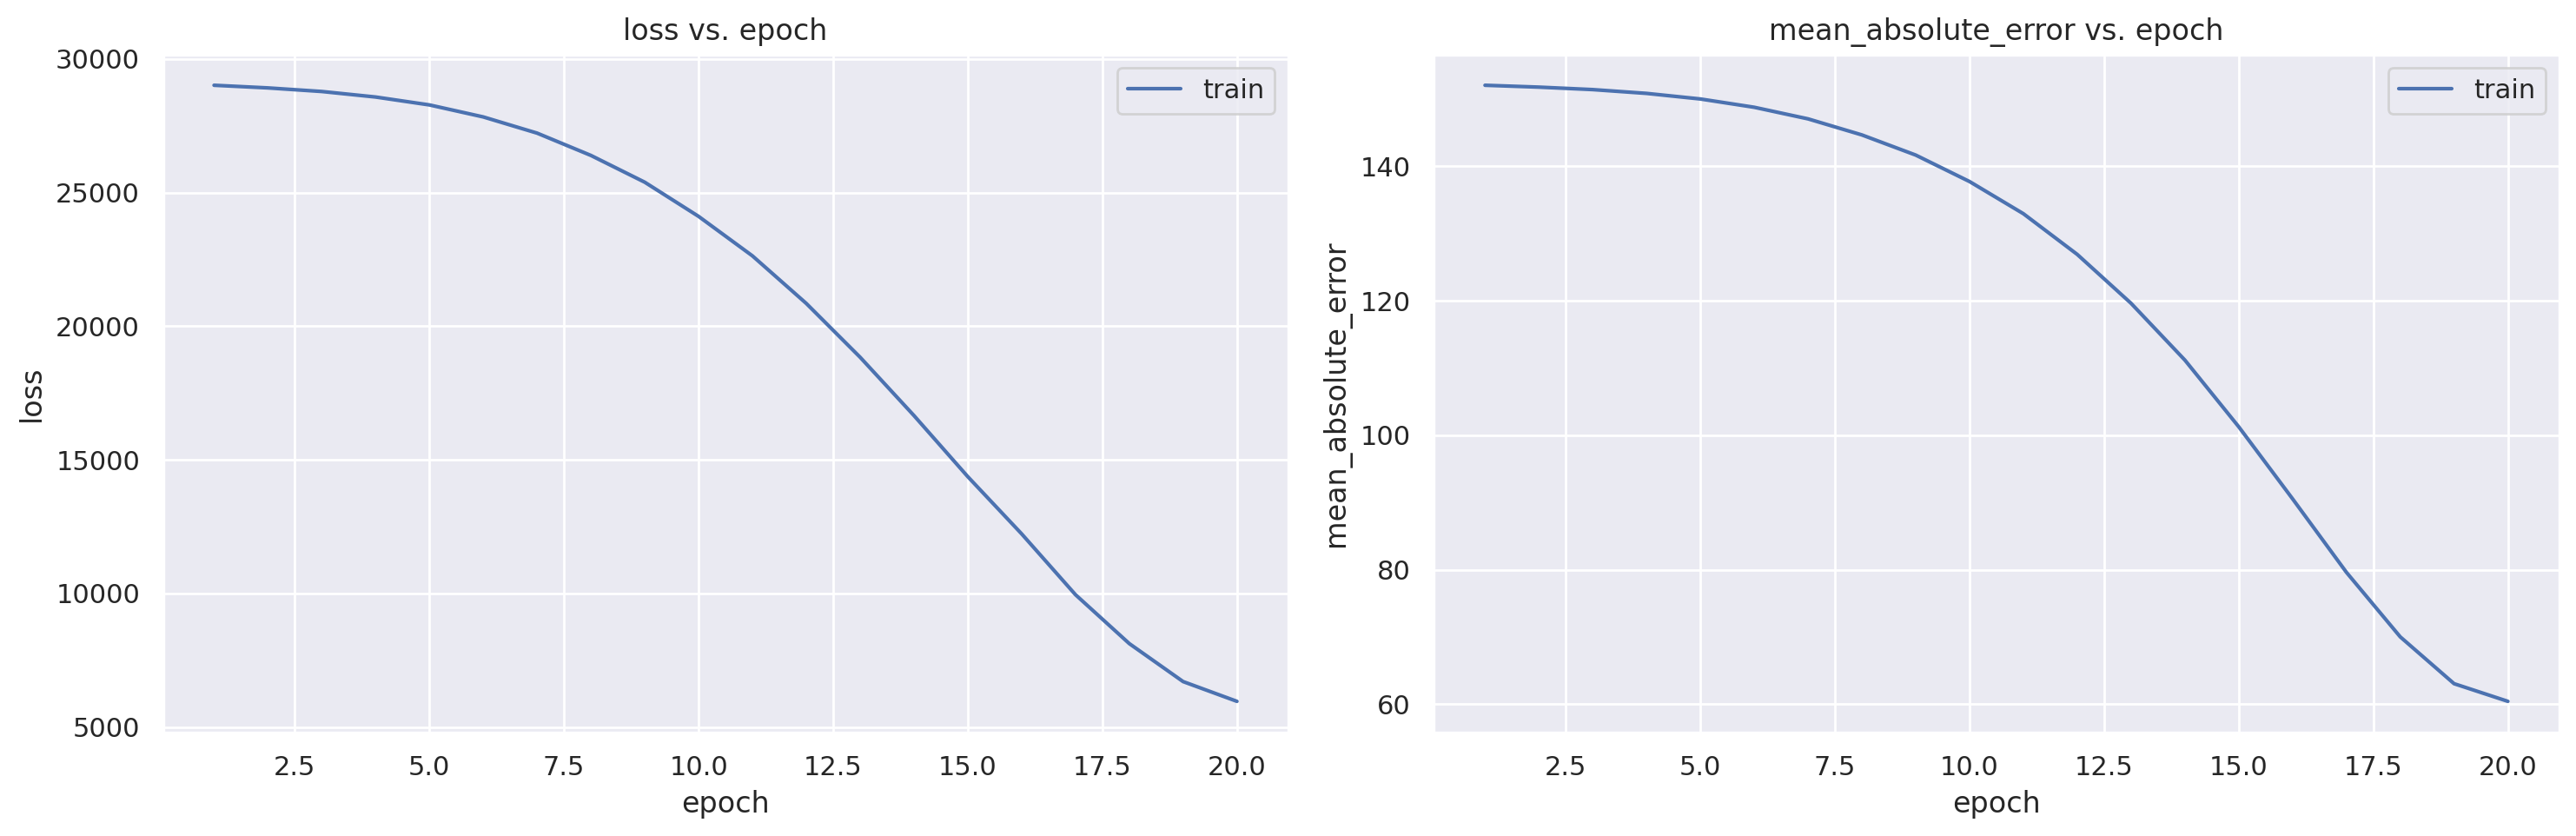

In [10]:
# Train the model
history = model.fit(train_data, train_targets, epochs=20, 
    batch_size=100, callbacks=[LossAndMetricCallback()], verbose=0)

# Plot training history
PlotHistory(history, metrics=['loss', 'mean_absolute_error'])\
    .plot()

We can also use our callback in the `evaluate` function...

In [11]:
# Evaluate the model
model_eval = model.evaluate(test_data, test_targets, batch_size=10,
    callbacks=[LossAndMetricCallback()], verbose=0)


 After batch 0, the loss is 17675.16.

 After batch 1, the loss is 23564.38.

 After batch 2, the loss is 21981.78.

 After batch 3, the loss is 19074.45.

 After batch 4, the loss is 17809.92.


...And also the `predict` function.

In [12]:
# Get predictions from the model
model_pred = model.predict(test_data, batch_size=10,
    callbacks=[LossAndMetricCallback()], verbose=0)

Finished prediction on batch 0!
Finished prediction on batch 1!
Finished prediction on batch 2!
Finished prediction on batch 3!
Finished prediction on batch 4!


### Application - learning rate scheduler
Let's now look at a more sophisticated custom callback.

We are going to define a callback to change the learning rate of the optimiser of a model during training. We will do this by specifying the epochs and new learning rates where we would like it to be changed.

First we define the auxillary function that returns the learning rate for each epoch based on our schedule.

In [13]:
# Define the learning rate schedule. The tuples below are 
# (start_epoch, new_learning_rate)
lr_schedule = [(4, 0.03), (7, 0.02), (11, 0.005), (15, 0.007)]

def get_new_epoch_lr(epoch, lr):
    # Checks to see if the input epoch is listed in the learning rate
    # schedule and if so, returns index in lr_schedule
    epoch_in_sched = [i for i in range(len(lr_schedule)) 
        if lr_schedule[i][0]==int(epoch)]
    if len(epoch_in_sched)>0:
        # If it is, return the learning rate corresponding to the epoch
        return lr_schedule[epoch_in_sched[0]][1]
    else:
        # Otherwise, return the existing learning rate
        return lr

Let's now define the callback itself.

In [14]:
# Define the custom callback
class LRScheduler(tf.keras.callbacks.Callback):
    
    def __init__(self, new_lr):
        super(LRScheduler, self).__init__()
        # Add the new learning rate function to our callback
        self.new_lr = new_lr
        
    def on_epoch_begin(self, epoch, logs=None):
        # Make sure that the optimizer we have chosen has a learning
        # rate, and raise an error if not
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError("Error: Optimizer does not have a learning rate.")
            
        # Get the current learning rate
        curr_rate = float(tf.keras.backend.get_value(
            self.model.optimizer.lr))
        
        # Call the auxillary function to get the scheduled learning rate 
        # for the current epoch
        scheduled_rate = self.new_lr(epoch, curr_rate)
        
        # Set the learning rate to the scheduled learning rate
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_rate)
        print("Learning rate for epoch {} is {:7.3f}".format(
            epoch, scheduled_rate))

Let's now train the model again with our new callback

In [15]:
# Build the same model as before
new_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', 
        input_shape=(train_data.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Print the model summary
print(new_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               1408      
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                      

In [16]:
# Compile the model
new_model.compile(
    loss=tf.keras.losses.MeanSquaredError(), 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()])

print(new_model.loss)
print(new_model.optimizer)
print(new_model.metrics)

[]


Learning rate for epoch 0 is   0.001
Learning rate for epoch 1 is   0.001
Learning rate for epoch 2 is   0.001
Learning rate for epoch 3 is   0.001
Learning rate for epoch 4 is   0.030
Learning rate for epoch 5 is   0.030
Learning rate for epoch 6 is   0.030
Learning rate for epoch 7 is   0.020
Learning rate for epoch 8 is   0.020
Learning rate for epoch 9 is   0.020
Learning rate for epoch 10 is   0.020
Learning rate for epoch 11 is   0.005
Learning rate for epoch 12 is   0.005
Learning rate for epoch 13 is   0.005
Learning rate for epoch 14 is   0.005
Learning rate for epoch 15 is   0.007
Learning rate for epoch 16 is   0.007
Learning rate for epoch 17 is   0.007
Learning rate for epoch 18 is   0.007
Learning rate for epoch 19 is   0.007


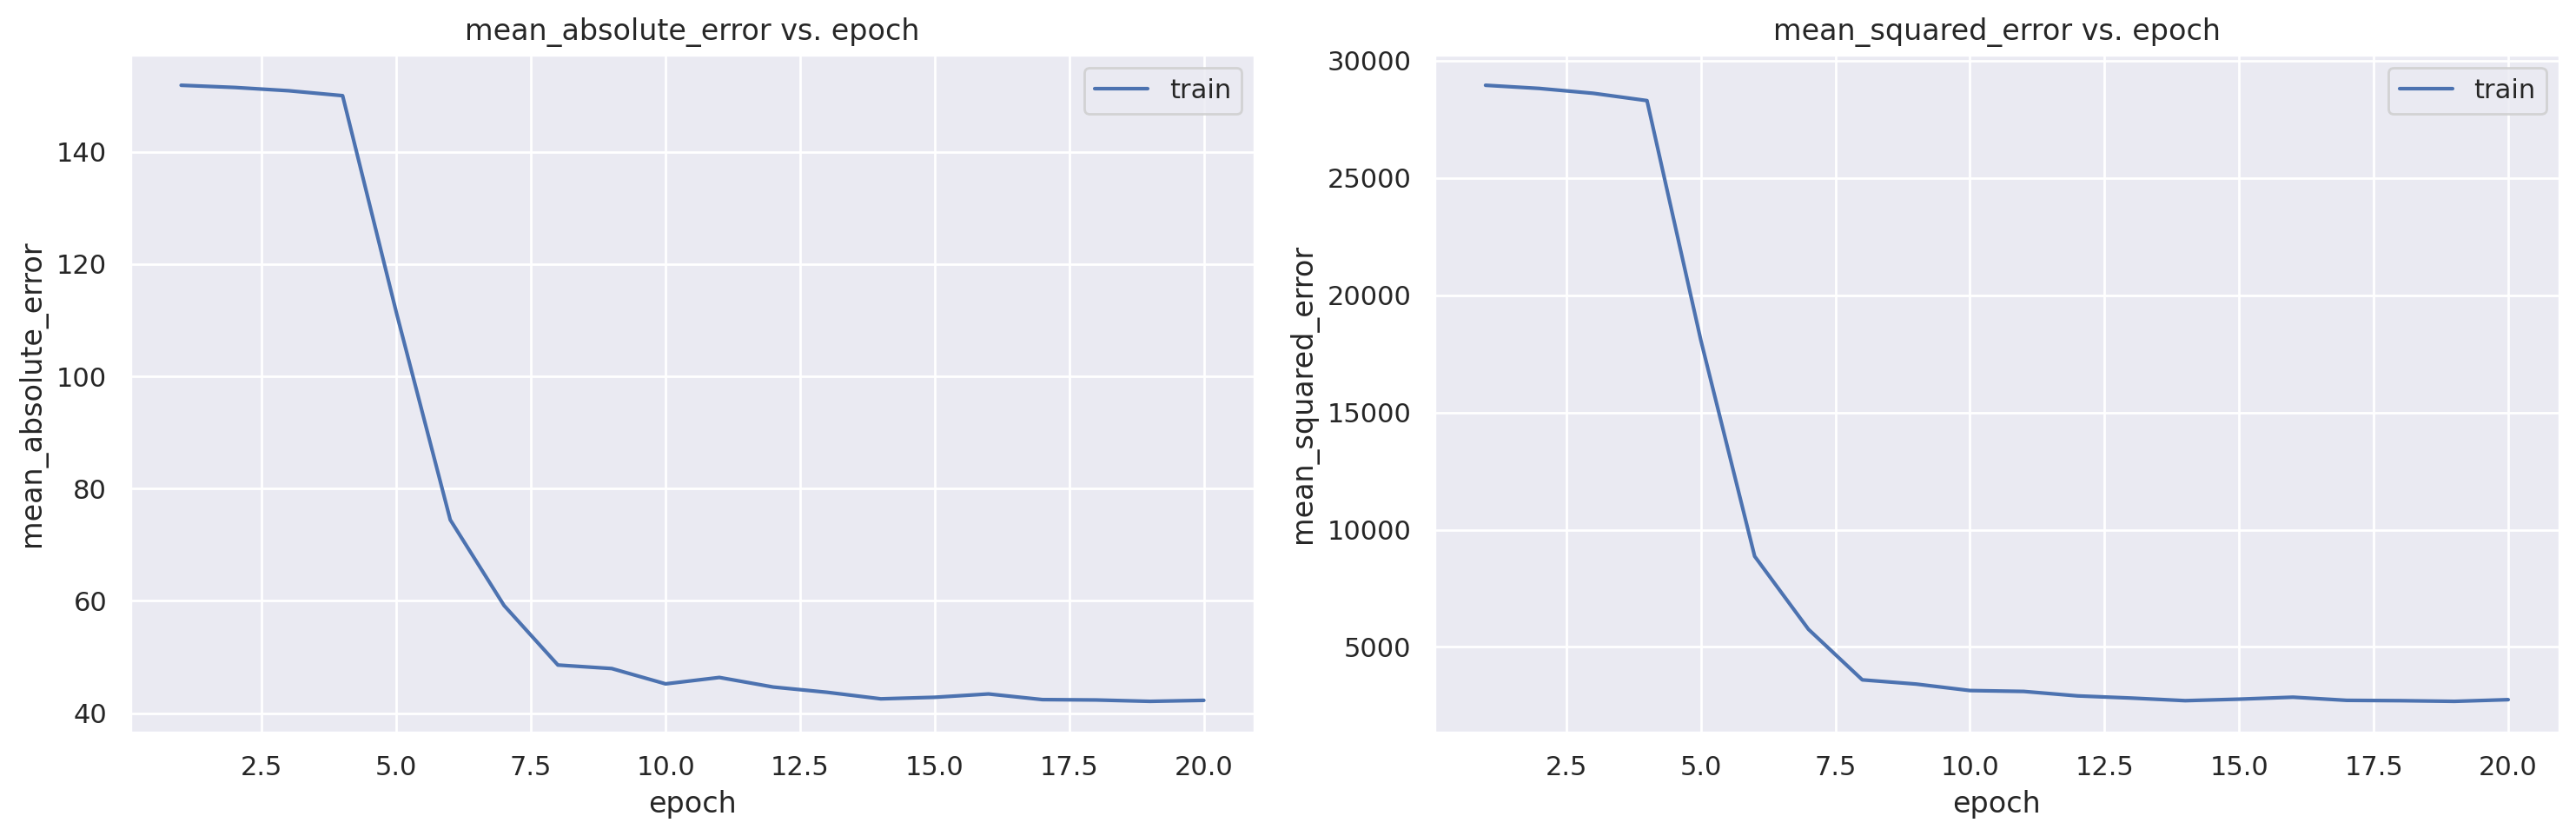

In [17]:
# Fit the model with our learning rate scheduler callback
new_history = new_model.fit(train_data, train_targets, epochs=20,
    batch_size=100, callbacks=[LRScheduler(get_new_epoch_lr)],
    verbose=0)

# Plot training history
PlotHistory(new_history, metrics=['mean_absolute_error', 'mean_squared_error'])\
    .plot()

### Further reading and resources
* https://www.tensorflow.org/guide/keras/custom_callback
* https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback